# Training a Reverse Denoising Model 

## Introduction
We have now completed the forward diffusion process and compared the performance of the mean and noise based loss function. It is time to run some training to denoise the noisy output from the forward diffusion process and retrieve the original input. 

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
from typing import List, Tuple
from tqdm import tqdm
import itertools

In [2]:
import jax.numpy as jnp
from jax import value_and_grad, jit, vmap, random
from jax import Array
from jax.config import config
config.update("jax_debug_nans", True)
config.update("jax_array", True)

## Building the denoising model
We first build the denoising model by initializing a U-Net style linear model. A U-Net consists of a contracting path and an expansive path. We adopted an upside-down U-shape structure to build the denoising model. The input image we will use has a small dimension, so we first increase the dimension for each layer to increase the expressive power of the model and then decrease the dimension back to the image size. 

We have implemented the initializer function that takes in the list of input and output dimensions for each layer. 


In [3]:
def init_layer(key, in_dims: List[int], out_dim: int) -> List[Array]:
    """
    Initialize weight and bias terms for a layer that takes in inputs with
    dimensions in_dims and then outputs values with dimension out_dim.

    in_dims: dimensions of the input, i.e. in_dim[0] x 1, in_dim[1] x 1, ...
    out_dim: dimension of the output, i.e. out_dim x 1

    Return the weight matrices and bias vector for the layer.

    weight: out_dim x in_dim[0], out_dim x in_dim[1], ...
    bias: out_dim x 1
    """
    b_key, *w_keys = random.split(key, num=len(in_dims) + 1)
    weights = []
    for w_key, in_dim in zip(w_keys, in_dims):
        bound = jnp.sqrt(1 / in_dim)
        weight = random.uniform(w_key, (out_dim, in_dim), minval=-bound, maxval=bound)
        weights.append(weight)
    bias = random.uniform(b_key, (out_dim,), minval=-bound, maxval=bound)
    return weights + [bias]


def init_unet(key, sizes: List[int]) -> List[List[Array]]:
    """
    Initialize a U-Net style linear model with layer input and output
    dimensions from sizes. When sizes is of length N, the resulting model
    will contain 2 * (N-1) + 1 layers.

    key: random.PRNGKey(seed), used for randomness in initialization.
    sizes: list of integers to be used for layer dimension sizes.

    Return a list of layer parameters, where each layer is described as a
    list of the form: (weight, bias) for layers 1 through N and
    (prev_weight, res_weight, bias) for layers (N+1) through (2N-1).
    """
    n = len(sizes)
    key, *layer_keys = random.split(key, num=2 * n)

    model = []
    for i in jnp.arange(n - 1):
        # (weight, bias)
        layer = init_layer(layer_keys[i], [sizes[i]], sizes[i + 1])
        model.append(layer)

    # (weight, bias)
    layer = init_layer(layer_keys[n - 1], [sizes[n - 1]], sizes[n - 1])
    model.append(layer)

    for i in jnp.flip(jnp.arange(1, n)):
        # (prev_weight, res_weight, bias)
        layer = init_layer(
            layer_keys[n + i - 1], [sizes[i], sizes[i - 1]], sizes[i - 1]
        )
        model.append(layer)

    return model


Use the initializer function to initialize a U-Net model with a list of layers dimensions. 

In [4]:
model_key = random.PRNGKey(0)
# BEGIN SOLUTION
model = init_unet(model_key, [9, 6, 4])
# END SOLUTION
for i, layer in enumerate(model):
    print(f"Layer {i}:")
    for j, weight in enumerate(layer[:-1]):
        print(f"\tW{j}: {weight.shape}")
    bias = layer[-1]
    print(f"\tb : {bias.shape}")

Layer 0:
	W0: (6, 9)
	b : (6,)
Layer 1:
	W0: (4, 6)
	b : (4,)
Layer 2:
	W0: (4, 4)
	b : (4,)
Layer 3:
	W0: (6, 4)
	W1: (6, 6)
	b : (6,)
Layer 4:
	W0: (9, 6)
	W1: (9, 9)
	b : (9,)


Run the following cell to get two activation functions, Sigmoid and ReLu. 

In [5]:
@jit
def sigmoid(x: Array) -> Array:
    """
    Compute the element-wise sigmoid of x.
    """
    return 0.5 * (jnp.tanh(x / 2) + 1)


@jit
def relu(x: Array) -> Array:
    """
    Compute the element-wise RELU of x.
    """
    return jnp.maximum(0, x)

The U-Net model aims to denoise the state at each of the timesteps as a way to approximate the forward denoising process distribution. 
Run the following cell to get the predictor function that takes in a list of models, a list of states for each timestep, and the number of timesteps. Choose an activation function to use, ReLu or Sigmoid. 

In [6]:
@jit
def predict(model: List[List[Array]], x: Array, t: int) -> Array:
    """
    Return the prediction of the U-Net model for given inputs x and t.

    x: state at time t
    t: number of timesteps
    """
    n = len(model)
    mid = n // 2
    xt = jnp.append(x, t)

    res_xt = []
    for i in range(0, mid):
        res_xt.append(xt)
        weight, bias = model[i]
        xt = relu(jnp.dot(weight, xt) + bias)
        # xt = sigmoid(jnp.dot(weight, xt) + bias)

    weight, bias = model[mid]
    xt = relu(jnp.dot(weight, xt) + bias)
    # xt = sigmoid(jnp.dot(weight, xt) + bias)

    for i in range(mid + 1, n):
        prev_weight, res_weight, bias = model[i]
        xt = jnp.dot(prev_weight, xt) + jnp.dot(res_weight, res_xt.pop()) + bias
        if i < n - 1:
            xt = relu(xt)
            # xt = sigmoid(xt)

    return xt[:-1]


Once we obtain the predicted initial starting state, we can compare the predicted and target states by computing the Mean Squared Error. We also provide the forward diffusion function that computes the noisy state given initial starting state, variance schedule, and randomly sampled Gaussian noise. 

In [7]:
@jit
def mse_loss(output: Array, target: Array) -> Array:
    """
    Return the MSE (Mean Squared Error) loss between the target and output.
    """
    D = jnp.prod(jnp.array(target.shape))
    error = target - output
    return jnp.sum((error).dot(error)) / D


@jit
def forward_diffuse(x_init: Array, t: int, var_schedule: Array, noise: Array) -> Array:
    """
    Compute x from the initial starting state, the given variance schedule,
    and the randomly sampled Gaussian noise.

    x_init: initial state
    t: number of timesteps to run forward diffusion for
    var_schedule: variance schedule of length t (timesteps)
    noise: randomly sampled Gaussian noise for diffusing x_init

    Return value:
    x: state after diffusing x_init for t timesteps
    """
    alpha = jnp.cumprod(var_schedule)[t]
    return jnp.sqrt(alpha) * x_init + jnp.sqrt(1 - alpha) * noise


Run the following cell to vectorize the predictor, mse_loss, and forward_diffuse functions in order to run batches of inputs. 

In [8]:
# vectorize these functions to be able to run batches of inputs
batched_predict = vmap(predict, in_axes=(None, 0, 0))
batched_mse_loss = vmap(mse_loss, in_axes=(0, 0))
batched_forward_diffuse = vmap(forward_diffuse, in_axes=(0, 0, None, 0))

## Training the Model

As we have worked through in Problem 3 Reverse “Denoising” Process, the objective is to obtain a reverse process distribution that approximates the forward diffusion process distribution. Motivated by the KL divergence loss, the loss function can be parameterized to compare the mean of the predicted distribution and the mean of the target distribution. The loss function is further reparameterized to compare the noise instead of the mean. Note that we make a design choice of having the variance of the predicted distribution to be set to the variances defined from the variance schedule. 

In our implementation, we will use the noise based loss function to train the denoising model. Run the following cell to obtain the training and update functions. 


In [9]:
@jit
def training_loss(
    key,
    model: List[List[Array]],
    x_init: Array,
    var_schedule: Array,
) -> Array:
    """
    Compute x(t) for every input in the batched x_init, predict the noise,
    and return the mean of the loss between predicted and target noise.

    key: random.PRNGKey used for seeding randomness
    model: parameters of the model to be trained
    x_init: batched inputs
    var_schedule: variance schedule
    """
    batch_size, n = x_init.shape
    t_key, noise_key = random.split(key, num=2)

    t = random.uniform(
        t_key, shape=(batch_size, 1), minval=0, maxval=len(var_schedule)
    ).astype(int)
    noise = random.multivariate_normal(
        noise_key, jnp.zeros(n), jnp.eye(n), shape=(batch_size,)
    )

    x = batched_forward_diffuse(x_init, t, var_schedule, noise)
    output_noise = batched_predict(model, x, t)
    return jnp.mean(batched_mse_loss(output_noise, noise))


@jit
def update(
    key,
    model: List[List[Array]],
    x_init: Array,
    var_schedule: Array,
    step_size: float,
) -> Tuple[Array, List[List[Array]]]:
    """
    Compute gradient update and return the loss and the updated model.

    key: random.PRNGKey used for seeding randomness
    model: parameters of the model to be trained
    x_init: batched_inputs
    var_schedule: variance schedule
    step_size: step size of gradient step
    """
    loss, grads = value_and_grad(training_loss, argnums=1)(
        key, model, x_init, var_schedule
    )

    updated_model = []
    for parameters, gradients in zip(model, grads):
        layer = []
        for parameter, gradient in zip(parameters, gradients):
            layer.append(parameter - step_size * gradient)
        updated_model.append(layer)

    return loss, updated_model


Define the input dimensions and variance schedule. 


In [10]:
# define input characteristics
input_shape = (3, 3)
input_dim = int(jnp.prod(jnp.array(input_shape)))
var_schedule = jnp.flip(jnp.array([0.1 * i for i in range(1, 5)]))
print(var_schedule)

[0.4 0.3 0.2 0.1]


Set the training data to be a single dot image. 

In [11]:
# number of samples
n = 100 

data = jnp.array([[0, 0, 0], [0, 1, 0], [0, 0, 0]]).flatten()
training_data = jnp.repeat(jnp.array([data]), n, axis=0)

print(training_data.shape)
print()
print(f"Example input:\n{data.reshape(input_shape)}")

(100, 9)

Example input:
[[0 0 0]
 [0 1 0]
 [0 0 0]]


Initialize the model and set the hyperparameters.


In [12]:
# initialize model
model_key = random.PRNGKey(1)
model = init_unet(model_key, [input_dim + 1, 200, 1000])

# hyperparameters to be changed
step_sizes = [1.7, 1.5, 1.3]
total_epochs = 3000

Train the denoising model and plot the losses over epochs. 


In [13]:
training_key = random.PRNGKey(2)

# calculated values
keys = random.split(training_key, num=total_epochs)
epoch_progress = tqdm(
    list(itertools.product(step_sizes, range(total_epochs // len(step_sizes))))
)

epoch_losses = []
for subkey, (step_size, _) in zip(keys, epoch_progress):
    x = training_data
    loss, model = update(subkey, model, x, var_schedule, step_size)

    # update tqdm progress bar with current loss
    epoch_progress.set_postfix_str(f"Loss {loss}")
    epoch_losses.append(loss)

trained_model = model


100%|█████████▉| 2999/3000 [00:53<00:00, 55.70it/s, Loss 0.00021490809740498662]


Minimum epoch_loss found: 0.00015775758947711438
Last loss found: 0.00021490809740498662


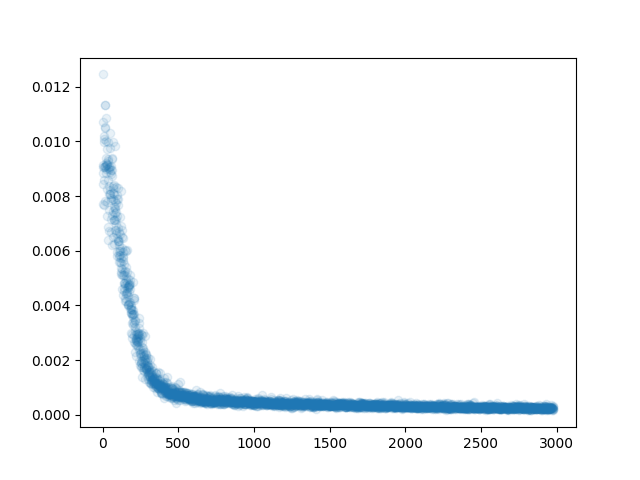

In [14]:
print(f"Minimum epoch_loss found: {jnp.min(jnp.array(epoch_losses))}")
print(f"Last loss found: {epoch_losses[-1]}")

for _ in range(20):
    # Close any prior plots
    plt.close()

plt.scatter(range(len(epoch_losses[20:])), epoch_losses[20:], alpha=0.1)
plt.show()

## Visualize the states in the reverse denoising process
Now that we have obtained the predicted noise, we can use it to visualize the state for each timestep in the reverse denoising process. By generating each state in the forward diffusion process and reverse denoising process, we can see if we are able to retrieve the original input, the single dot image. 

In [15]:
@jit
def reverse_diffuse(x: Array, t: int, var_schedule: Array, noise: Array) -> Array:
    """
    Compute x(t-1) from x(t) (the state at t), the given variance schedule,
    and the predicted noise.

    x: state after diffusing x_init for t timesteps
    var_schedule: variance schedule of length t (timesteps)
    noise: predicted noise

    Return value:
    x(t-1): (predicted) previous state
    """
    alpha = jnp.cumprod(var_schedule)[t]
    beta = var_schedule[t]
    return (x - beta * noise / jnp.sqrt(1 - alpha)) / jnp.sqrt(1 - beta)


@jit
def generate(
    key, x_init: Array, var_schedule: Array, model: List[List[Array]]
) -> Array:
    x = x_init
    subkeys = random.split(key, num=len(var_schedule) - 1)
    for key, t in zip(subkeys, jnp.flip(jnp.arange(1, len(var_schedule)))):
        # predict noise for denoising
        noise = predict(model, x, t)
        # reverse diffuse one step
        x = reverse_diffuse(x, t, var_schedule, noise)
        # sample Gaussian noise for adding more variance
        z = random.multivariate_normal(key, jnp.zeros(input_dim), jnp.eye(input_dim))
        # add sampled Gaussian noise to x
        x = x + jnp.sqrt(var_schedule[t]) * z

    # x(1) -> x(0) with no additional Gaussian noise
    noise = predict(model, x, 0)
    return reverse_diffuse(x, 0, var_schedule, noise)


Again, vectorize the functions to enable batch processing. 


In [16]:
batched_reshape = vmap(jit(lambda x: x.reshape(input_shape)))
batched_generate = vmap(generate, in_axes=(0, 0, None, None))

### Visualize the States

In [17]:
from utils import show_plots

Sample the noise that is added to the input during the forward diffusion process. 
Obtain the diffused state at each time step. 

In [18]:
num_samples = 5

# sample x(t) states to pass into the generator
x_key = random.PRNGKey(19)
x_init_noise = random.multivariate_normal(
    x_key, jnp.zeros(input_dim), jnp.eye(input_dim), shape=(num_samples,)
)
x_init_diffused = batched_forward_diffuse(
    training_data[:num_samples],
    jnp.repeat(1, num_samples),
    var_schedule[:1],
    x_init_noise,
)

Generate the predicted noise and the predicted diffused states. 


In [19]:
generate_key = random.PRNGKey(20)
subkeys = random.split(generate_key, num=num_samples)

x_from_noise = batched_generate(
    subkeys, x_init_noise, var_schedule[:1], trained_model
)
x_from_diffused = batched_generate(
    subkeys, x_init_diffused, var_schedule[:1], trained_model
)

Run the following cells to show the visualizations. 


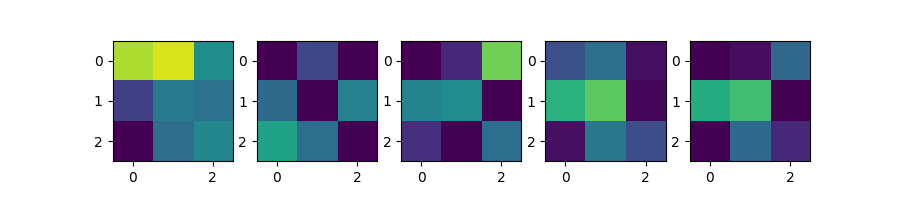

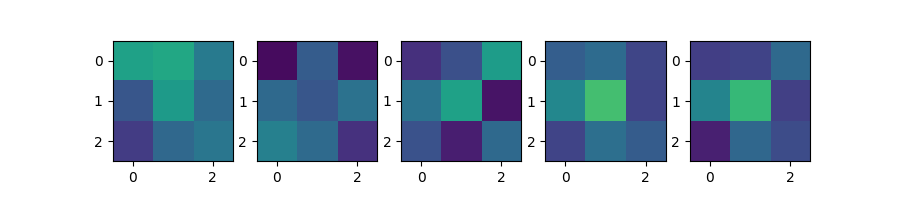

In [20]:
show_plots(batched_reshape(x_init_noise), standard=True)
show_plots(batched_reshape(x_from_noise), standard=True)

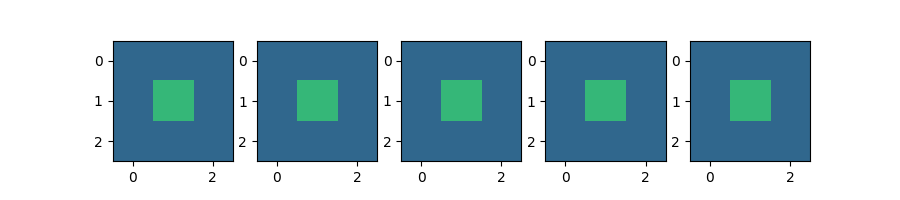

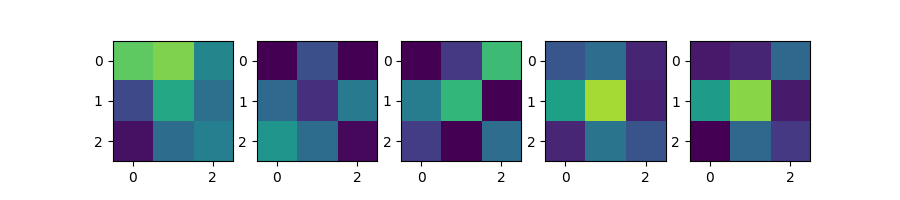

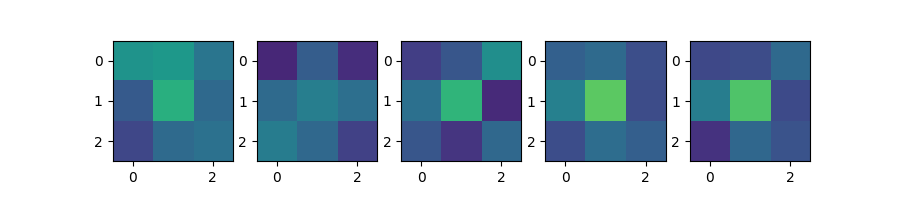

In [21]:
show_plots(batched_reshape(training_data[:num_samples]), standard=True)
show_plots(batched_reshape(x_init_diffused), standard=True)
show_plots(batched_reshape(x_from_diffused), standard=True)

In [28]:
# uncomment and run this if there are too many plots open
# "Figure x" at the top of the current figure means there are x plots open;
# the notebook might complain once x >= 20

# for _ in jnp.arange(30):
#     plt.close()

### Compare the states from the forward process and backward process. Comment on what you observe. 